<a href="https://colab.research.google.com/github/mickaelrebeau/Colab-Repo/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textblob
!pip install textblob_fr
!pip install transformers

     |████████████████████████████████| 563kB 7.6MB/s 
     |████████████████████████████████| 2.0MB 8.2MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
     |████████████████████████████████| 3.2MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=d23cfe10dfa2cbcfce249b44f862deec76f0212ecd12eba6701852b9a4d75857
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 7.4MB/s 


In [ ]:
# Pour lire un csv depuis drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pandas as pd 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import json
import time
import torch
import datetime
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1BV8NG91_HV_Uqy8oTrp0MVNdnxTL9wxU/view?usp=sharing
fileDownload = drive.CreateFile({'id':'1BV8NG91_HV_Uqy8oTrp0MVNdnxTL9wxU'})
fileDownload.GetContentFile('restaurant.csv')

In [ ]:
df = pd.read_csv('restaurant.csv',index_col=0)

In [ ]:
AComment=[]
for comment in df['avis'].apply(str):
    mots = []
    for word in  re.sub("\W"," ",comment ).split():
        mots.append(word)
    AComment.append(mots)

In [ ]:
df['mots'] = AComment

In [ ]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [ ]:
AllfilteredComment=[]
for comment in df['mots']:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))

In [ ]:
df['motsFiltrer'] = AllfilteredComment

In [ ]:
senti_list = []
for i in df['motsFiltrer']:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral') 

In [ ]:
df['sentiment'] = senti_list

In [ ]:
fig = px.histogram(df, x="sentiment",color="sentiment")
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

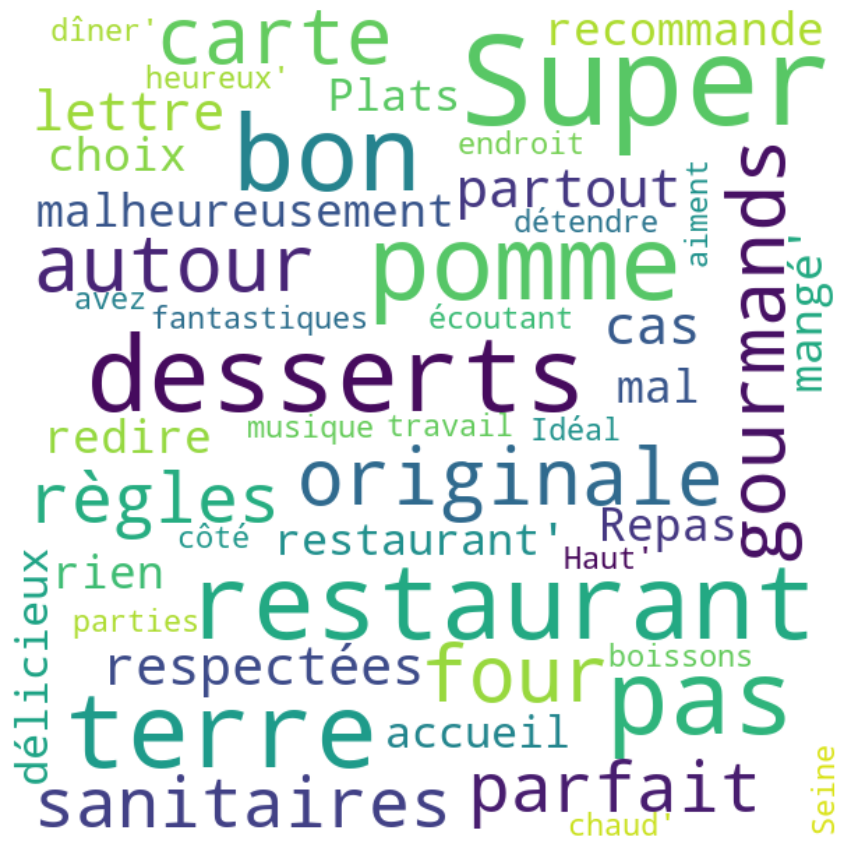

In [ ]:
 text = str(df['motsFiltrer'].values)
def plot_word_cloud(text) :
    
    # Définir le calque du nuage des mots
    wc = WordCloud(width=600,height=600,background_color="white", max_words=100, stopwords=stop_words, max_font_size=90,collocations = False, random_state=42)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (15,20))
    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.show()
plot_word_cloud(text)

In [ ]:
df['sentiment'] = df['sentiment'].replace('Positive',1)
df['sentiment'] = df['sentiment'].replace('Neutral',2)
df['sentiment'] = df['sentiment'].replace('Negative',0)

In [ ]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 16
device = torch.device('cuda')

In [ ]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [ ]:
# Creates list of texts and labels
text = df['avis'].to_list()
labels = df['sentiment'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,truncation=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=3)
model.to(device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

print("Model saved!")
torch.save(model.state_dict(), "sentiments.pt")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.4182171991817197


Epoch:  20%|██        | 1/5 [01:43<06:55, 104.00s/it]

Validation Accuracy: 0.8974025974025973
Train loss: 0.22487078681398107


Epoch:  40%|████      | 2/5 [03:27<05:11, 103.93s/it]

Validation Accuracy: 0.9292207792207792
Train loss: 0.14061737351537662


Epoch:  60%|██████    | 3/5 [05:11<03:27, 103.87s/it]

Validation Accuracy: 0.9303571428571428
Train loss: 0.08791245004371265


Epoch:  80%|████████  | 4/5 [06:55<01:43, 103.83s/it]

Validation Accuracy: 0.9280844155844156
Train loss: 0.0545915397040888


Epoch: 100%|██████████| 5/5 [08:38<00:00, 103.79s/it]

Validation Accuracy: 0.9443181818181818
Model saved!


In [ ]:
#https://drive.google.com/file/d/1uwiGdOMiQeIj5MLO7tlg0HI97mY3bNMr/view?usp=sharing
fileDownload1 = drive.CreateFile({'id':'1uwiGdOMiQeIj5MLO7tlg0HI97mY3bNMr'})
fileDownload1.GetContentFile('toto.csv')

In [ ]:
# Test the model on a comment
#comments = ["La vie est très mauvaise, Je la déteste", "Quelle belle voiture c'est très magnifique", "Ce matin un lapin tirait sur un chasseur", "Le Soleil brille il fait très beau!", "Oups ! Le repas était trop cuit, dégoutant !"]
data = pd.read_csv('toto.csv', index_col=0)

In [ ]:
data = data.dropna()

In [ ]:
data

,avis
0,J' ai pas les mots faite d urgence des travaux...
1,Très mal entretenue douche boucher et entenbe ...
2,"Une catastrophe,Un vrai taudis.Quelle honteOn ..."
3,"Hôtel peu chère, j'ai réserver sur tripadviso..."
4,"Désespérant : un radiateur crasseux, la porte ..."
...,...
1022,Belle chambre dans une grande ville
1023,Bon et sympathique
1024,Laissez-moi une chambre à 3 heures du matin
1025,Correct


In [ ]:
comments = data['avis']

In [ ]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Apply the finetuned model (Camembert)
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [ ]:
for i in range(len(flat_pred)):
    print('Comment: ', comments[i])
    print('Label', flat_pred[i])

Comment:  J' ai pas les mots faite d urgence des travaux les photos c est ce que regarde le client. Dans sa chambreMettez-vous dans la place du client que feriez-vous ?
Label 2
Comment:  Très mal entretenue douche boucher et entenbe télévision vraiment de traquer malheureusement. Mise à part cela l'accueil est correctement bien. Dommage pour la vétusté des chambre. Jais fait trois chambres avec nos colegue c dommage nous sommes même parie ou cela
Label 0
Comment:  Une catastrophe,Un vrai taudis.Quelle honteOn ferme des restaurants propre pour cause covid, et on laisse un endroit crasseux comme ça ouvert
Label 0
Comment:  Hôtel peu chère, j'ai réserver sur  tripadvisor (36€) mais à l'arriver j'ai dû me rendre à la borne automatique et j'ai mis mon numéro de réservation, et surprise j'ai dû re payer en plus (40€). La porte de la salle de bain était cassée et …
Label 0
Comment:  Désespérant : un radiateur crasseux, la porte de la douche qui ne ferme plus, la prise crasseuse qui ne fonctio